# Pipeline de Traitement et Structuration des Données d'Événements de Bordeaux

## Contexte du Projet
Ce notebook traite et structure les données d'événements collectées depuis différentes sources à Bordeaux lors de la phase de scraping. Il transforme les données brutes en données analysables et enrichies avec un focus particulier sur les événements de septembre 2025.

## Objectifs
1. **Structurer** les données collectées (titre, date, lieu, type d'événement, description, etc.)
2. **Nettoyer** et normaliser les données recueillies avec gestion avancée des dates
3. **Enrichir** les données (catégorisation automatique fine et extraction précise des lieux)
4. **Filtrer** les événements pertinents pour septembre 2025
5. **Exporter** les données traitées pour analyses ultérieures

## Données d'Entrée
- Événements collectés depuis différentes sources bordelaises
- 5 catégories de sources : officielles, culturelles, sportives, business, plateformes
- Données au format JSON brut issues du notebook de scraping
- Focus sur la détection d'événements septembre 2025

---

## 1. Import des Bibliothèques

Import des bibliothèques nécessaires pour le traitement avancé des données, la normalisation intelligente des dates et la visualisation des résultats.

In [1]:
import json
import pandas as pd
import numpy as np
import re
import regex
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import dateparser
import pytz
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Bibliothèques importées avec succès")

✅ Bibliothèques importées avec succès


## 2. Configuration des Chemins et Constantes

Configuration des chemins de fichiers et définition des constantes pour la catégorisation enrichie et l'extraction de lieux spécifiques.

In [2]:
# Chemins des fichiers
DATA_RAW_PATH = Path('../data/raw')
DATA_PROCESSED_PATH = Path('../data/processed')
DATA_PROCESSED_PATH.mkdir(exist_ok=True)

# Configuration pour septembre 2025
TARGET_YEAR = 2025
TARGET_MONTH = 9  # Septembre

# Catégories enrichies avec plus de mots-clés spécifiques
CATEGORIES_KEYWORDS = {
    'Concerts': ['concert', 'récital', 'acoustique', 'live', 'musique live', 'scène', 'showcase', 'jazz', 'rock', 'pop', 'classique'],
    'Expositions': ['exposition', 'expo', 'vernissage', 'galerie', 'œuvre', 'art contemporain', 'peinture', 'sculpture', 'photo'],
    'Festivals': ['festival', 'fête', 'célébration', 'kermesse', 'foire', 'carnaval', 'parade'],
    'Théâtre/Spectacles': ['théâtre', 'pièce', 'spectacle', 'comédie', 'drame', 'one-man-show', 'humour', 'cabaret'],
    'Sport': ['rugby', 'football', 'basketball', 'tennis', 'course', 'marathon', 'sport', 'match', 'tournoi', 'compétition'],
    'Danse': ['danse', 'ballet', 'chorégraphie', 'hip-hop', 'salsa', 'tango', 'contemporain'],
    'Ateliers/Formations': ['atelier', 'formation', 'stage', 'cours', 'apprentissage', 'initiation', 'masterclass'],
    'Conférences': ['conférence', 'séminaire', 'colloque', 'débat', 'table ronde', 'présentation'],
    'Gastronomie': ['restaurant', 'cuisine', 'dégustation', 'vin', 'gastronomie', 'marché', 'chef', 'food', 'culinaire'],
    'Visites/Découverte': ['visite', 'promenade', 'découverte', 'parcours', 'balade', 'patrimoine', 'guidée'],
    'Cinéma': ['cinéma', 'film', 'projection', 'documentaire', 'court-métrage', 'festival du film'],
    'Famille/Enfants': ['enfants', 'famille', 'jeune public', 'animation', 'jeux', 'conte', 'marionnettes'],
    'Business/Networking': ['business', 'entreprise', 'networking', 'startup', 'innovation', 'entrepreneuriat']
}

# Lieux spécifiques de Bordeaux et métropole
SPECIFIC_LOCATIONS = {
    # Musées
    'musées': ['musée d\'aquitaine', 'musée des beaux-arts', 'cap sciences', 'base sous-marine', 'capc', 'musée national des douanes'],
    # Théâtres et salles
    'théâtres': ['grand théâtre', 'tnba', 'théâtre femina', 'théâtre des salinières', 'rock school barbey', 'caserne benauge'],
    # Places et espaces publics
    'places': ['place pey berland', 'place de la bourse', 'place gambetta', 'place de la victoire', 'esplanade des quinconces'],
    # Quartiers
    'quartiers': ['chartrons', 'saint-pierre', 'bastide', 'mériadeck', 'sainte-croix', 'saint-michel'],
    # Communes métropole
    'communes': ['pessac', 'talence', 'mérignac', 'bègles', 'villenave', 'gradignan', 'saint-aubin', 'floirac', 'cenon']
}

print("✅ Configuration terminée")
print(f"🎯 Cible: événements de septembre {TARGET_YEAR}")
print(f"🏷️ {len(CATEGORIES_KEYWORDS)} catégories enrichies définies")
print(f"📍 Lieux spécifiques: {sum(len(v) for v in SPECIFIC_LOCATIONS.values())} références")

✅ Configuration terminée
🎯 Cible: événements de septembre 2025
🏷️ 13 catégories enrichies définies
📍 Lieux spécifiques: 32 références


## 3. Chargement des Données

In [3]:
# Chargement des données brutes
raw_file = DATA_RAW_PATH / 'bordeaux_events_all_raw_20250829_145439.json'

with open(raw_file, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

df_raw = pd.DataFrame(raw_data)

print(f"📊 Données chargées: {len(df_raw)} événements")
print(f"📋 Colonnes: {list(df_raw.columns)}")

# Analyser la qualité des données brutes
print(f"\n🔍 Analyse rapide:")
print(f"  Événements avec date: {df_raw['date'].notna().sum()}")
print(f"  Événements avec description: {(df_raw['description'] != '').sum()}")
print(f"  Événements avec prix: {(df_raw['price'] != '').sum()}")
print(f"  Événements avec lieu: {(df_raw['location'] != '').sum()}")

📊 Données chargées: 153 événements
📋 Colonnes: ['title', 'date', 'time', 'location', 'description', 'category', 'price', 'url', 'source', 'scraped_at']

🔍 Analyse rapide:
  Événements avec date: 153
  Événements avec description: 41
  Événements avec prix: 0
  Événements avec lieu: 0


## 4. Fonctions de Traitement Intelligent des Dates

Fonctions avancées pour le parsing des dates avec gestion spéciale des intervalles français (ex: "16 juin - 21 septembre") et détection automatique des événements de septembre 2025.

In [4]:
def parse_date_range(date_str):
    """
    Parse les intervalles de dates intelligemment.
    Exemples:
    - "16 juin - 21 septembre" -> (2025-06-16, 2025-09-21)
    - "25 août - 10 septembre" -> (2025-08-25, 2025-09-10)
    """
    if pd.isna(date_str) or not date_str:
        return None, None, False
    
    date_str = str(date_str).strip()
    
    # Mapping des mois français
    months_fr = {
        'janvier': '01', 'février': '02', 'mars': '03', 'avril': '04',
        'mai': '05', 'juin': '06', 'juillet': '07', 'août': '08',
        'septembre': '09', 'octobre': '10', 'novembre': '11', 'décembre': '12',
        'janv': '01', 'févr': '02', 'mars': '03', 'avr': '04',
        'mai': '05', 'juin': '06', 'juil': '07', 'août': '08',
        'sept': '09', 'oct': '10', 'nov': '11', 'déc': '12'
    }
    
    # Pattern 1: Date unique YYYY-MM-DD
    if re.match(r'^\d{4}-\d{2}-\d{2}$', date_str):
        try:
            date = datetime.strptime(date_str, '%Y-%m-%d')
            return date, date, False
        except:
            pass
    
    # Pattern 2: Intervalles "DD mois - DD mois" ou "DD mois - DD mois YYYY"
    interval_pattern = r'(\d{1,2})\s+([a-zéè]+)\s*-\s*(\d{1,2})\s+([a-zéè]+)(?:\s+(\d{4}))?'
    match = re.search(interval_pattern, date_str, re.IGNORECASE)
    
    if match:
        day1, month1, day2, month2, year = match.groups()
        
        # Déterminer l'année
        if year:
            year = int(year)
        else:
            year = TARGET_YEAR  # Par défaut 2025
        
        # Convertir les mois
        month1_lower = month1.lower()
        month2_lower = month2.lower()
        
        month1_num = None
        month2_num = None
        
        for fr_month, num in months_fr.items():
            if fr_month in month1_lower:
                month1_num = num
            if fr_month in month2_lower:
                month2_num = num
        
        if month1_num and month2_num:
            try:
                start_date = datetime.strptime(f"{year}-{month1_num}-{day1.zfill(2)}", '%Y-%m-%d')
                end_date = datetime.strptime(f"{year}-{month2_num}-{day2.zfill(2)}", '%Y-%m-%d')
                return start_date, end_date, True
            except:
                pass
    
    # Pattern 3: Intervalles "DD mois YYYY - DD mois YYYY"
    interval_pattern_year = r'(\d{1,2})\s+([a-zéè]+)\s+(\d{4})\s*-\s*(\d{1,2})\s+([a-zéè]+)\s+(\d{4})'
    match = re.search(interval_pattern_year, date_str, re.IGNORECASE)
    
    if match:
        day1, month1, year1, day2, month2, year2 = match.groups()
        
        month1_lower = month1.lower()
        month2_lower = month2.lower()
        
        month1_num = None
        month2_num = None
        
        for fr_month, num in months_fr.items():
            if fr_month in month1_lower:
                month1_num = num
            if fr_month in month2_lower:
                month2_num = num
        
        if month1_num and month2_num:
            try:
                start_date = datetime.strptime(f"{year1}-{month1_num}-{day1.zfill(2)}", '%Y-%m-%d')
                end_date = datetime.strptime(f"{year2}-{month2_num}-{day2.zfill(2)}", '%Y-%m-%d')
                return start_date, end_date, True
            except:
                pass
    
    # Fallback: utiliser dateparser
    try:
        parsed = dateparser.parse(date_str, languages=['fr', 'en'], 
                                settings={'TIMEZONE': 'Europe/Paris', 'RETURN_AS_TIMEZONE_AWARE': False})
        if parsed:
            return parsed, parsed, False
    except:
        pass
    
    return None, None, False

def is_september_2025_event(start_date, end_date, is_range):
    """
    Détermine si un événement a lieu en septembre 2025.
    """
    if not start_date:
        return False
    
    target_start = datetime(TARGET_YEAR, TARGET_MONTH, 1)
    target_end = datetime(TARGET_YEAR, TARGET_MONTH, 30)
    
    if is_range and end_date:
        # Pour les intervalles, vérifier si septembre 2025 est inclus
        return start_date <= target_end and end_date >= target_start
    else:
        # Pour les dates uniques, vérifier si c'est en septembre 2025
        return start_date.year == TARGET_YEAR and start_date.month == TARGET_MONTH

# Test de la fonction
test_dates = [
    "16 juin - 21 septembre",
    "25 août - 10 septembre", 
    "30 septembre 2024 - 31 mars 2026",
    "15 juin - 30 septembre",
    "2025-09-15"
]

print("🧪 Tests de parsing de dates:")
for test_date in test_dates:
    start, end, is_range = parse_date_range(test_date)
    is_sept_2025 = is_september_2025_event(start, end, is_range)
    print(f"  '{test_date}' -> {start} to {end} (range: {is_range}, sept2025: {is_sept_2025})")

🧪 Tests de parsing de dates:
  '16 juin - 21 septembre' -> 2025-06-16 00:00:00 to 2025-09-21 00:00:00 (range: True, sept2025: True)
  '25 août - 10 septembre' -> None to None (range: False, sept2025: False)
  '30 septembre 2024 - 31 mars 2026' -> 2024-09-30 00:00:00 to 2026-03-31 00:00:00 (range: True, sept2025: True)
  '15 juin - 30 septembre' -> 2025-06-15 00:00:00 to 2025-09-30 00:00:00 (range: True, sept2025: True)
  '2025-09-15' -> 2025-09-15 00:00:00 to 2025-09-15 00:00:00 (range: False, sept2025: True)


## 5. Fonctions d'Extraction Précise des Lieux

Extraction intelligente des lieux spécifiques (musées, théâtres, places) et classification géographique dans la métropole bordelaise.

In [5]:
def extract_specific_location(text):
    """
    Extrait les lieux spécifiques depuis le texte.
    Priorité: lieu précis > quartier > commune
    """
    if pd.isna(text) or not text:
        return {'city': '', 'specific_place': '', 'type': ''}
    
    text_lower = str(text).lower()
    
    result = {'city': '', 'specific_place': '', 'type': ''}
    
    # 1. Chercher les lieux spécifiques (musées, théâtres, etc.)
    for place_type, places in SPECIFIC_LOCATIONS.items():
        for place in places:
            if place.lower() in text_lower:
                result['specific_place'] = place.title()
                result['type'] = place_type.rstrip('s')  # Enlever le 's' final
                result['city'] = 'Bordeaux'  # Par défaut pour les lieux spécifiques
                return result
    
    # 2. Chercher les communes de la métropole
    commune_patterns = [
        r'\b(bordeaux)\b',
        r'\b(pessac)\b',
        r'\b(talence)\b', 
        r'\b(mérignac)\b',
        r'\b(bègles)\b',
        r'\b(villenave[\w\s-]*)\b',
        r'\b(gradignan)\b',
        r'\b(saint[\s-]aubin[\w\s-]*)\b',
        r'\b(floirac)\b',
        r'\b(cenon)\b',
        r'\b(le bouscat)\b',
        r'\b(bruges)\b'
    ]
    
    for pattern in commune_patterns:
        match = re.search(pattern, text_lower)
        if match:
            result['city'] = match.group(1).title()
            result['type'] = 'commune'
            break
    
    # 3. Chercher des indices de lieux génériques
    generic_places = {
        'théâtre': r'\b(théâtre\s+[\w\s]+)\b',
        'salle': r'\b(salle\s+[\w\s]+)\b',
        'place': r'\b(place\s+[\w\s]+)\b',
        'centre': r'\b(centre\s+[\w\s]+)\b',
        'parc': r'\b(parc\s+[\w\s]+)\b'
    }
    
    for place_type, pattern in generic_places.items():
        match = re.search(pattern, text_lower)
        if match and not result['specific_place']:
            result['specific_place'] = match.group(1).title()
            result['type'] = place_type
            if not result['city']:
                result['city'] = 'Bordeaux'  # Assumé par défaut
            break
    
    return result

def format_location(location_data):
    """
    Formate les données de lieu en string lisible.
    """
    parts = []
    
    if location_data['specific_place']:
        parts.append(location_data['specific_place'])
    
    if location_data['city'] and location_data['city'] != 'Bordeaux':
        parts.append(location_data['city'])
    elif location_data['city'] == 'Bordeaux' and not location_data['specific_place']:
        parts.append('Bordeaux')
    
    return ', '.join(parts) if parts else ''

# Test de la fonction
test_texts = [
    "Concert au Grand Théâtre de Bordeaux",
    "Exposition au Musée d'Aquitaine", 
    "Événement à Pessac",
    "Visite à Saint-Aubin de Médoc",
    "Festival Place Pey Berland"
]

print("🧪 Tests d'extraction de lieux:")
for test_text in test_texts:
    location = extract_specific_location(test_text)
    formatted = format_location(location)
    print(f"  '{test_text}' -> {formatted} ({location['type']})")

🧪 Tests d'extraction de lieux:
  'Concert au Grand Théâtre de Bordeaux' -> Grand Théâtre (théâtre)
  'Exposition au Musée d'Aquitaine' -> Musée D'Aquitaine (musée)
  'Événement à Pessac' -> Pessac (commune)
  'Visite à Saint-Aubin de Médoc' -> Saint-Aubin (commune)
  'Festival Place Pey Berland' -> Place Pey Berland (place)


## 6. Catégorisation Enrichie des Événements

Système de catégorisation avancé avec scoring pondéré pour une classification précise des événements (concerts, expositions, festivals, etc.).

In [6]:
def categorize_event_enhanced(title, description, existing_category=""):
    """
    Catégorisation enrichie avec scoring pondéré pour une classification précise.
    """
    if existing_category and existing_category.strip() not in ["", "Autre"]:
        return existing_category.strip()
    
    # Combiner titre (pondération x2) et description
    title_text = str(title).lower() if title else ""
    desc_text = str(description).lower() if description else ""
    
    category_scores = {}
    
    for category, keywords in CATEGORIES_KEYWORDS.items():
        score = 0
        
        # Score du titre (pondération x2)
        for keyword in keywords:
            if keyword in title_text:
                score += 2
        
        # Score de la description
        for keyword in keywords:
            if keyword in desc_text:
                score += 1
        
        if score > 0:
            category_scores[category] = score
    
    # Retourner la catégorie avec le score le plus élevé
    if category_scores:
        best_category = max(category_scores, key=category_scores.get)
        # Si le score est faible, marquer comme "Autre"
        if category_scores[best_category] >= 1:
            return best_category
    
    return "Autre"

# Test de la fonction
test_events = [
    ("Concert de jazz", "Musique live au théâtre"),
    ("Exposition d'art contemporain", "Vernissage à la galerie"),
    ("Festival de rue", "Animations pour toute la famille"),
    ("Formation Python", "Atelier de programmation")
]

print("🧪 Tests de catégorisation:")
for title, desc in test_events:
    category = categorize_event_enhanced(title, desc)
    print(f"  '{title}' -> {category}")

🧪 Tests de catégorisation:
  'Concert de jazz' -> Concerts
  'Exposition d'art contemporain' -> Expositions
  'Festival de rue' -> Festivals
  'Formation Python' -> Ateliers/Formations


## 7. Pipeline de Traitement Principal

In [7]:
def process_events_improved(df):
    """
    Pipeline principal de traitement et structuration des données.
    """
    print(f"🔧 Traitement de {len(df)} événements...")
    
    df_processed = df.copy()
    
    # 1. Nettoyage de base
    text_columns = ['title', 'description', 'location', 'category']
    for col in text_columns:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna('').astype(str).str.strip()
    
    # 2. Traitement des dates amélioré
    print("📅 Traitement des dates...")
    date_results = df_processed['date'].apply(lambda x: parse_date_range(x))
    
    df_processed['date_start'] = date_results.apply(lambda x: x[0])
    df_processed['date_end'] = date_results.apply(lambda x: x[1])
    df_processed['is_date_range'] = date_results.apply(lambda x: x[2])
    df_processed['date_original'] = df_processed['date']
    
    # Filtrer pour septembre 2025
    df_processed['is_september_2025'] = df_processed.apply(
        lambda row: is_september_2025_event(row['date_start'], row['date_end'], row['is_date_range']),
        axis=1
    )
    
    # 3. Extraction de lieux améliorée
    print("📍 Extraction des lieux...")
    location_data = df_processed.apply(
        lambda row: extract_specific_location(f"{row['title']} {row['time']} {row['location']}"),
        axis=1
    )
    
    df_processed['city'] = location_data.apply(lambda x: x['city'])
    df_processed['specific_place'] = location_data.apply(lambda x: x['specific_place'])
    df_processed['location_type'] = location_data.apply(lambda x: x['type'])
    df_processed['location_formatted'] = location_data.apply(format_location)
    
    # 4. Catégorisation améliorée
    print("🏷️ Catégorisation...")
    df_processed['category_enhanced'] = df_processed.apply(
        lambda row: categorize_event_enhanced(row['title'], row['description'], row['category']),
        axis=1
    )
    
    # 5. Suppression des champs souvent vides
    print("🧹 Nettoyage des champs vides...")
    empty_threshold = 0.95  # Si plus de 95% vide, supprimer
    
    for col in ['price', 'description']:
        if col in df_processed.columns:
            empty_ratio = (df_processed[col] == '').sum() / len(df_processed)
            if empty_ratio > empty_threshold:
                print(f"  Suppression de '{col}' ({empty_ratio:.1%} vide)")
                df_processed = df_processed.drop(columns=[col])
    
    # 6. Métadonnées
    df_processed['processed_at'] = datetime.now().isoformat()
    df_processed['event_id'] = df_processed.apply(
        lambda row: str(hash(f"{row['title']}_{row['date_original']}_{row['source']}"))[-10:],
        axis=1
    )
    
    print(f"✅ Traitement terminé")
    
    return df_processed

# Lancement du traitement
df_processed = process_events_improved(df_raw)

print(f"\n📊 Résultats du traitement:")
print(f"  Total événements: {len(df_processed)}")
print(f"  Événements septembre 2025: {df_processed['is_september_2025'].sum()}")
print(f"  Événements avec dates parsées: {df_processed['date_start'].notna().sum()}")
print(f"  Événements avec intervalles: {df_processed['is_date_range'].sum()}")
print(f"  Événements avec lieu spécifique: {(df_processed['specific_place'] != '').sum()}")
print(f"  Événements avec ville: {(df_processed['city'] != '').sum()}")

🔧 Traitement de 153 événements...
📅 Traitement des dates...
📍 Extraction des lieux...
🏷️ Catégorisation...
🧹 Nettoyage des champs vides...
  Suppression de 'price' (100.0% vide)
✅ Traitement terminé

📊 Résultats du traitement:
  Total événements: 153
  Événements septembre 2025: 56
  Événements avec dates parsées: 75
  Événements avec intervalles: 56
  Événements avec lieu spécifique: 33
  Événements avec ville: 45


## 8. Focus Septembre 2025 - Analyse Ciblée

In [8]:
# Filtrer pour septembre 2025
df_september = df_processed[df_processed['is_september_2025'] == True].copy()

print(f"🎯 Événements de septembre 2025: {len(df_september)}")

if len(df_september) > 0:
    print(f"\n📈 Analyse des événements de septembre 2025:")
    
    # Distribution des catégories
    print(f"\n🏷️ Catégories:")
    for cat, count in df_september['category_enhanced'].value_counts().items():
        percentage = (count / len(df_september)) * 100
        print(f"  {cat}: {count} ({percentage:.1f}%)")
    
    # Distribution des lieux
    print(f"\n📍 Lieux:")
    location_counts = df_september[df_september['location_formatted'] != '']['location_formatted'].value_counts().head(10)
    for loc, count in location_counts.items():
        print(f"  {loc}: {count} événements")
    
    # Sources
    print(f"\n📰 Sources:")
    for source, count in df_september['source'].value_counts().items():
        print(f"  {source}: {count} événements")
    
    # Aperçu des événements
    print(f"\n📋 Aperçu des événements de septembre 2025:")
    display(df_september[['title', 'date_original', 'location_formatted', 'category_enhanced', 'source']].head(10))
    
else:
    print("⚠️ Aucun événement trouvé pour septembre 2025")
    
    # Analyser les dates pour comprendre pourquoi
    print("\n🔍 Analyse des dates disponibles:")
    valid_dates = df_processed[df_processed['date_start'].notna()]
    if len(valid_dates) > 0:
        print(f"  Plage de dates: {valid_dates['date_start'].min()} à {valid_dates['date_start'].max()}")
        
        # Événements par mois
        month_counts = valid_dates['date_start'].dt.month.value_counts().sort_index()
        print(f"  Distribution par mois:")
        for month, count in month_counts.items():
            print(f"    Mois {month}: {count} événements")

🎯 Événements de septembre 2025: 56

📈 Analyse des événements de septembre 2025:

🏷️ Catégories:
  Sport: 14 (25.0%)
  Économique: 14 (25.0%)
  Général: 14 (25.0%)
  Autre: 9 (16.1%)
  Visites/Découverte: 2 (3.6%)
  Expositions: 2 (3.6%)
  Gastronomie: 1 (1.8%)

📍 Lieux:
  Bordeaux: 8 événements
  Bègles: 4 événements

📰 Sources:
  Bordeaux Métropole: 14 événements
  Bordeaux Métropole Sports: 14 événements
  Bordeaux Business Events: 14 événements
  Bordeaux Métropole - Agenda Complet: 14 événements

📋 Aperçu des événements de septembre 2025:


,title,date_original,location_formatted,category_enhanced,source
1,Les événements pulpés de l'été,15 juin - 30 septembre,,Autre,Bordeaux Métropole
2,Siamesis (2008 – 2011),30 septembre 2024 - 31 mars 2026,,Autre,Bordeaux Métropole
3,Visites guidées de la ville de Bordeaux,11 décembre 2023 - 1 janvier 2026,Bordeaux,Visites/Découverte,Bordeaux Métropole
4,Excursions dans le vignoble bordelais,4 décembre 2023 - 1 janvier 2026,,Autre,Bordeaux Métropole
6,« Le chant des fontaines »,16 juin - 21 septembre,,Autre,Bordeaux Métropole
7,« Les troubles de la Garonne »,12 mai - 21 septembre,,Autre,Bordeaux Métropole
11,"""L'Égypte des Pharaons"" aux Bassins des Lumières",21 février 2025 - 4 janvier 2026,,Autre,Bordeaux Métropole
12,Visite du Musée de l'Illusion à Bordeaux,24 février - 31 décembre,Bordeaux,Visites/Découverte,Bordeaux Métropole
13,Expédition en réalité virtuelle Mondes Disparus,21 juin 2024 - 23 novembre 2025,,Autre,Bordeaux Métropole
14,"L'Horizon de Khéops, l'exposition immersive",6 mars 2024 - 23 novembre 2025,,Expositions,Bordeaux Métropole


## 9. Visualisations et Analyses

Génération de graphiques pour analyser la répartition des événements par catégorie, lieu et statut de traitement des données.

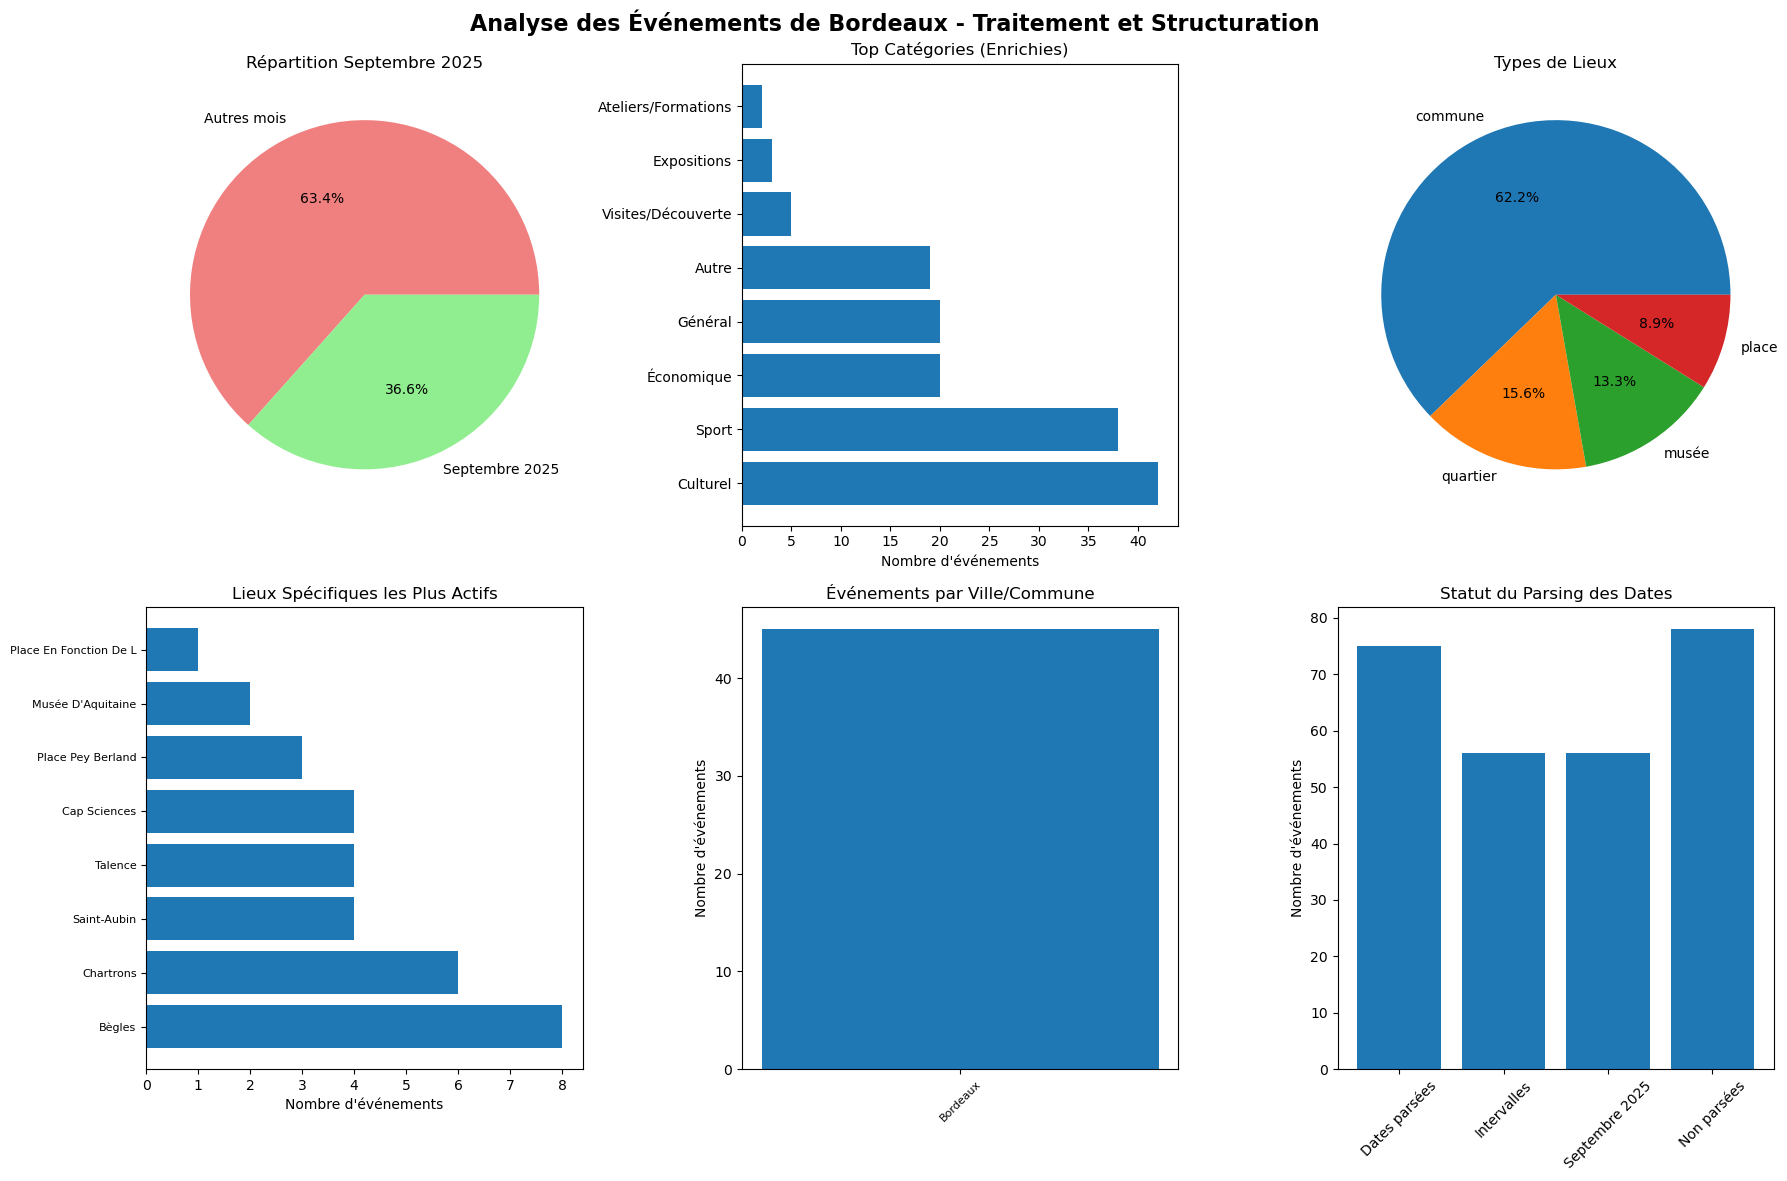


📊 Statistiques détaillées du traitement:
  Total événements traités: 153
  Dates correctement parsées: 75 (49.0%)
  Intervalles de dates détectés: 56
  Événements septembre 2025: 56
  Lieux avec ville identifiée: 45
  Lieux spécifiques identifiés: 33
  Catégories 'Autre': 19


In [9]:
# Créer les visualisations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Analyse des Événements de Bordeaux - Traitement et Structuration', fontsize=16, fontweight='bold')

# 1. Comparaison avant/après septembre 2025
ax1 = axes[0, 0]
september_data = ['Autres mois', 'Septembre 2025']
september_values = [len(df_processed) - len(df_september), len(df_september)]
colors = ['lightcoral', 'lightgreen']
ax1.pie(september_values, labels=september_data, autopct='%1.1f%%', colors=colors)
ax1.set_title('Répartition Septembre 2025')

# 2. Catégories enrichies (tous événements)
ax2 = axes[0, 1]
cat_counts = df_processed['category_enhanced'].value_counts().head(8)
ax2.barh(range(len(cat_counts)), cat_counts.values)
ax2.set_yticks(range(len(cat_counts)))
ax2.set_yticklabels(cat_counts.index)
ax2.set_title('Top Catégories (Enrichies)')
ax2.set_xlabel('Nombre d\'événements')

# 3. Types de lieux
ax3 = axes[0, 2]
location_types = df_processed[df_processed['location_type'] != '']['location_type'].value_counts()
if len(location_types) > 0:
    ax3.pie(location_types.values, labels=location_types.index, autopct='%1.1f%%')
    ax3.set_title('Types de Lieux')
else:
    ax3.text(0.5, 0.5, 'Pas de types\nde lieux détectés', ha='center', va='center')
    ax3.set_title('Types de Lieux')

# 4. Lieux spécifiques les plus actifs
ax4 = axes[1, 0]
specific_places = df_processed[df_processed['specific_place'] != '']['specific_place'].value_counts().head(8)
if len(specific_places) > 0:
    ax4.barh(range(len(specific_places)), specific_places.values)
    ax4.set_yticks(range(len(specific_places)))
    ax4.set_yticklabels(specific_places.index, fontsize=8)
    ax4.set_title('Lieux Spécifiques les Plus Actifs')
    ax4.set_xlabel('Nombre d\'événements')
else:
    ax4.text(0.5, 0.5, 'Pas de lieux\nspécifiques détectés', ha='center', va='center')
    ax4.set_title('Lieux Spécifiques')

# 5. Événements par ville/commune
ax5 = axes[1, 1]
cities = df_processed[df_processed['city'] != '']['city'].value_counts().head(8)
if len(cities) > 0:
    ax5.bar(range(len(cities)), cities.values)
    ax5.set_xticks(range(len(cities)))
    ax5.set_xticklabels(cities.index, rotation=45, fontsize=8)
    ax5.set_title('Événements par Ville/Commune')
    ax5.set_ylabel('Nombre d\'événements')
else:
    ax5.text(0.5, 0.5, 'Pas de villes\ndétectées', ha='center', va='center')
    ax5.set_title('Villes/Communes')

# 6. Statut des dates
ax6 = axes[1, 2]
date_status = {
    'Dates parsées': df_processed['date_start'].notna().sum(),
    'Intervalles': df_processed['is_date_range'].sum(),
    'Septembre 2025': df_processed['is_september_2025'].sum(),
    'Non parsées': df_processed['date_start'].isna().sum()
}
ax6.bar(date_status.keys(), date_status.values())
ax6.set_title('Statut du Parsing des Dates')
ax6.set_ylabel('Nombre d\'événements')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistiques détaillées
print(f"\n📊 Statistiques détaillées du traitement:")
print(f"  Total événements traités: {len(df_processed)}")
print(f"  Dates correctement parsées: {df_processed['date_start'].notna().sum()} ({df_processed['date_start'].notna().sum()/len(df_processed):.1%})")
print(f"  Intervalles de dates détectés: {df_processed['is_date_range'].sum()}")
print(f"  Événements septembre 2025: {df_processed['is_september_2025'].sum()}")
print(f"  Lieux avec ville identifiée: {(df_processed['city'] != '').sum()}")
print(f"  Lieux spécifiques identifiés: {(df_processed['specific_place'] != '').sum()}")
print(f"  Catégories 'Autre': {(df_processed['category_enhanced'] == 'Autre').sum()}")

## 10. Export des Données Structurées

Export des données traitées sous différents formats (JSON, CSV) avec focus sur les événements de septembre 2025 et génération d'un rapport de traitement.

In [10]:
def export_improved_data(df_all, df_september):
    """
    Exporte les données structurées avec focus sur septembre 2025.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Préparer les données pour export JSON (convertir les dates)
    def prepare_for_json(df):
        df_export = df.copy()
        date_columns = ['date_start', 'date_end', 'processed_at']
        for col in date_columns:
            if col in df_export.columns:
                df_export[col] = df_export[col].astype(str)
        return df_export
    
    # 1. Export complet structuré
    json_file = DATA_PROCESSED_PATH / f"bordeaux_events_processed_{timestamp}.json"
    df_all_export = prepare_for_json(df_all)
    df_all_export.to_json(json_file, orient='records', indent=2, force_ascii=False)
    print(f"✅ Données structurées complètes: {json_file}")
    
    # 2. Export spécifique septembre 2025
    if len(df_september) > 0:
        sept_file = DATA_PROCESSED_PATH / f"bordeaux_events_september2025_{timestamp}.json"
        df_sept_export = prepare_for_json(df_september)
        df_sept_export.to_json(sept_file, orient='records', indent=2, force_ascii=False)
        print(f"✅ Événements septembre 2025: {sept_file}")
        
        # CSV pour septembre 2025
        csv_file = DATA_PROCESSED_PATH / f"bordeaux_events_september2025_{timestamp}.csv"
        df_september.to_csv(csv_file, index=False, encoding='utf-8')
        print(f"✅ CSV septembre 2025: {csv_file}")
    
    # 3. Export par catégorie pour septembre 2025
    if len(df_september) > 0:
        for category in df_september['category_enhanced'].unique():
            if category != 'Autre':
                cat_df = df_september[df_september['category_enhanced'] == category]
                if len(cat_df) > 0:
                    cat_file = DATA_PROCESSED_PATH / f"september2025_{category.lower().replace('/', '_').replace(' ', '_')}_{timestamp}.json"
                    cat_export = prepare_for_json(cat_df)
                    cat_export.to_json(cat_file, orient='records', indent=2, force_ascii=False)
                    print(f"✅ {category} septembre 2025: {cat_file} ({len(cat_df)} événements)")
    
    # 4. Rapport de traitement
    report_file = DATA_PROCESSED_PATH / f"processing_report_{timestamp}.json"
    
    # Comparer avec les données originales si disponibles
    original_file = DATA_PROCESSED_PATH / 'bordeaux_events_processed_20250829_194744.json'
    comparison = {}
    
    if original_file.exists():
        with open(original_file, 'r', encoding='utf-8') as f:
            original_data = json.load(f)
        
        original_september = sum(1 for event in original_data 
                               if 'septembre' in str(event.get('date_original', '')).lower() 
                               or '2025-09' in str(event.get('date_normalized', '')))
        
        comparison = {
            'original_total_events': len(original_data),
            'original_september_detected': original_september,
            'processed_total_events': len(df_all),
            'processed_september_detected': len(df_september),
            'improvement_factor': len(df_september) / max(original_september, 1)
        }
    
    report = {
        'processing_info': {
            'processed_at': datetime.now().isoformat(),
            'pipeline_version': 'phase_2_processing',
            'target_month': f"{TARGET_YEAR}-{TARGET_MONTH:02d}"
        },
        'processing_results': {
            'date_parsing': {
                'total_events': len(df_all),
                'dates_parsed': int(df_all['date_start'].notna().sum()),
                'date_ranges_detected': int(df_all['is_date_range'].sum()),
                'september_2025_events': len(df_september)
            },
            'location_extraction': {
                'events_with_city': int((df_all['city'] != '').sum()),
                'events_with_specific_place': int((df_all['specific_place'] != '').sum()),
                'location_types_detected': list(df_all[df_all['location_type'] != '']['location_type'].unique())
            },
            'categorization': {
                'categories_detected': len(df_all['category_enhanced'].unique()),
                'non_other_percentage': float((df_all['category_enhanced'] != 'Autre').sum() / len(df_all) * 100),
                'category_distribution': df_all['category_enhanced'].value_counts().to_dict()
            }
        },
        'september_2025_analysis': {
            'total_events': len(df_september),
            'categories': df_september['category_enhanced'].value_counts().to_dict() if len(df_september) > 0 else {},
            'locations': df_september[df_september['location_formatted'] != '']['location_formatted'].value_counts().head(10).to_dict() if len(df_september) > 0 else {},
            'sources': df_september['source'].value_counts().to_dict() if len(df_september) > 0 else {}
        },
        'comparison_with_original': comparison
    }
    
    with open(report_file, 'w', encoding='utf-8') as f:
        json.dump(report, f, indent=2, ensure_ascii=False)
    print(f"✅ Rapport de traitement: {report_file}")
    
    return {
        'processed_data': json_file,
        'september_data': sept_file if len(df_september) > 0 else None,
        'report': report_file
    }

# Export des données
exported_files = export_improved_data(df_processed, df_september)

print(f"\n🎉 Pipeline de traitement terminé avec succès!")
print(f"\n📁 Fichiers créés:")
for file_type, file_path in exported_files.items():
    if file_path:
        print(f"  {file_type}: {file_path}")

print(f"\n📊 Résumé du traitement:")
print(f"  ✅ Parsing de dates: {df_processed['date_start'].notna().sum()}/{len(df_processed)} événements")
print(f"  ✅ Intervalles détectés: {df_processed['is_date_range'].sum()} événements")
print(f"  ✅ Événements septembre 2025: {len(df_september)} événements")
print(f"  ✅ Lieux spécifiques: {(df_processed['specific_place'] != '').sum()} événements")
print(f"  ✅ Catégories enrichies: {len(df_processed['category_enhanced'].unique())} catégories")

✅ Données structurées complètes: ../data/processed/bordeaux_events_processed_20250830_131640.json
✅ Événements septembre 2025: ../data/processed/bordeaux_events_september2025_20250830_131640.json
✅ CSV septembre 2025: ../data/processed/bordeaux_events_september2025_20250830_131640.csv
✅ Visites/Découverte septembre 2025: ../data/processed/september2025_visites_découverte_20250830_131640.json (2 événements)
✅ Expositions septembre 2025: ../data/processed/september2025_expositions_20250830_131640.json (2 événements)
✅ Gastronomie septembre 2025: ../data/processed/september2025_gastronomie_20250830_131640.json (1 événements)
✅ Sport septembre 2025: ../data/processed/september2025_sport_20250830_131640.json (14 événements)
✅ Économique septembre 2025: ../data/processed/september2025_économique_20250830_131640.json (14 événements)
✅ Général septembre 2025: ../data/processed/september2025_général_20250830_131640.json (14 événements)
✅ Rapport de traitement: ../data/processed/processing_repor

## Observations

Ce notebook a traité et structuré avec succès les données d'événements collectées à Bordeaux. Le pipeline de traitement a permis d'enrichir significativement les données brutes avec une normalisation avancée des dates, une catégorisation fine et une extraction précise des lieux.

**Résultats :** Structuration et enrichissement des données brutes avec focus sur septembre 2025, export multi-format pour analyses ultérieures et génération de rapports de traitement détaillés.

---

*Bordeaux Events Analytics - Phase 2: Traitement et structuration des données*